In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.matplotlib.rcParams['savefig.dpi'] = 144
import seaborn

# Anomaly Detection, Session 2

In [2]:
import zipfile
import pandas as pd
import numpy as np
import glob
from sklearn import base
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.linear_model import LinearRegression
from sklearn import metrics

In [ ]:
def load_counts(fn):
    zf = zipfile.ZipFile(fn, 'r')
    df = pd.read_csv(zf.open(zf.namelist()[0]))
    counts = df['starttime'].str.split(' ', 1).apply(lambda x: x[0]).value_counts()
    if '-' in counts.index[0]:
        counts.index = pd.to_datetime(counts.index, format='%Y-%m-%d')
    else:
        counts.index = pd.to_datetime(counts.index, format='%m/%d/%Y')
    return counts.sort_index()

fns = glob.glob('tripdata/[0-9][0-9][0-9][0-9][0-9][0-9]-citibike-tripdata.zip')
counts = pd.concat([load_counts(fn) for fn in sorted(fns)])

In [3]:
def read_counts_csv(csv_n):
    df = pd.read_csv(csv_n, names=["date", "starttime"])
    df["dt"] = pd.to_datetime(df["date"])
    counts = df["starttime"]
    counts.index = df["dt"]
    counts.sort_index()
    return counts

counts = read_counts_csv("counts.csv")

In [4]:
class FourierComponents(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, period):
        self.period = period
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        dt = (X - self.X0).days * 2 * np.pi / self.period
        return np.c_[np.sin(dt), np.cos(dt)]

class DayofWeek(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def day_vector(self, day):
        v = np.zeros(7)
        v[day] = 1
        return v
    
    def transform(self, X):
        return np.stack(self.day_vector(d) for d in X.dayofweek)

class QuadBackground(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        self.X0 = X[0]
        return self
    
    def transform(self, X):
        days = (X - self.X0).days
        return np.c_[days, days**2]

We will start with a slightly more complex model than we ended the previous session with.  In addition to the yearly Fourier term and weekly binning, we have added monthly, bianual, and 8/year Fourier components.

In [5]:
union = FeatureUnion([('date', QuadBackground()),
                      ('fourier-y', FourierComponents(365)),
                      ('fourier-2', FourierComponents(365/2.)),
                      ('fourier-m', FourierComponents(365/12.)),
                      ('fourier-8', FourierComponents(365/8.)),
                      ('dayofweek', DayofWeek())])
pipe = Pipeline([('union', union),
                 ('lr', LinearRegression())])
pipe.fit(counts.index, counts.values)
np.sqrt(metrics.mean_squared_error(counts, pipe.predict(counts.index)))

5850.8116537276765

This is a fair improvement on our previous RMSE.

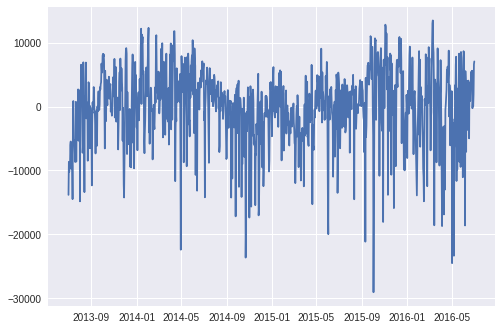

In [6]:
residuals = counts - pipe.predict(counts.index)
plt.plot(residuals)

## z-Score

From the residuals plot above, we can fairly easily see which values are likely to be anomalous: those far from zero.  We can quantify this measure with some results from statistics.

Let $X$ be a random variable described by a **probability distribution function** $p(x)$.  This means that the probability of $X$ being found between $a$ and $b$ is

$$ \int_a^b p(x)\,dx \ . $$

There are a number of quantities that describe a distribution; two of the most basic are the mean,

$$ \mu \equiv \int x\,p(x)\,dx\ , $$

and the standard deviation,

$$ \sigma \equiv \left[ \int (x - \mu )^2\,p(x)\,dx \right]^{1/2} \ . $$

The mean indicates the center of the distribution, while the standard deviation measures its width.

If we have a measurement $y$ and a distribution with $\mu$ and $\sigma$, the **z-score** measures the distance of $y$ from the mean, normalized by the standard deviation:

$$ z = \frac{y - \mu}\sigma \ . $$

Many random variables follow the Gaussian, or normal, distribution.  This is the common bell curve, which is parameterized by its mean and standard deviation:

$$ p(x) = \frac{1}{\sqrt{2 \pi} \sigma} \exp \left(\frac{(x - \mu)^2}{2 \sigma^2} \right) \ . $$

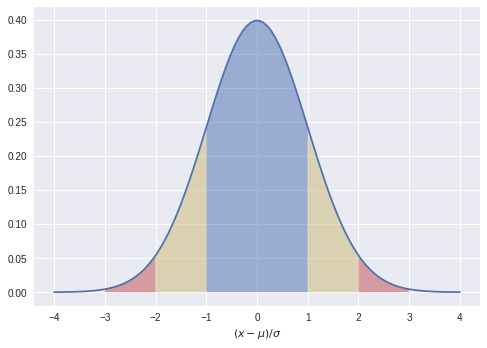

In [7]:
from scipy import stats
x = np.linspace(-4, 4, 100)
dist = stats.norm()
cols = seaborn.color_palette()[::2]
cols = [cols[1], cols[2], cols[0], cols[0], cols[2], cols[1]]
plt.plot(x, dist.pdf(x))
for xm in xrange(-2, 4):
    x = np.linspace(xm-1, xm, 20)
    plt.fill_between(x, dist.pdf(x), alpha=0.5, lw=0, facecolor=cols[xm+2])
plt.xlabel(r'$(x - \mu) / \sigma$')

For a Gaussian, there is 68% chance of a random variable lying within $1\sigma$ of the mean (blue), a 95% chance of it lying withing $2\sigma$ (blue and yellow), and a 99.7% chance of it lying within $3\sigma$ (blue, yellow and red).  Thus, the higher the z-score of a value, the less likely it is to have been drawn from that distribution.

Of course, different distributions have different shapes, so these probabilities are not universal.  Still, for single-peaked distributions, the general pattern holds.

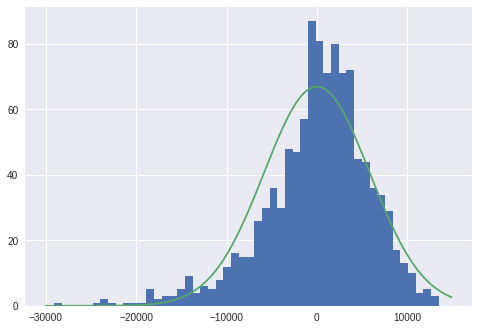

In [8]:
residuals.hist(bins=50)
x = np.arange(-30000, 15000, 100)
dist = stats.norm(scale=residuals.std())
plt.plot(x, dist.pdf(x) * 45000 / 50. * len(residuals))

The residuals are not distributed normally, but we can still use large (absolute) z-scores as an indicator.

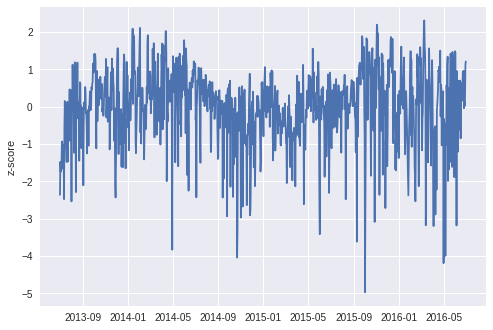

In [10]:
z = residuals / residuals.std()
plt.plot(z)
plt.ylabel('z-score')

Since the distrbution of residuals is not symmetric about 0, we will consider different thresholds for positive and negative z values.

In [11]:
z[z > 2]

dt
2014-01-13    2.081930
2014-02-02    2.103765
2014-04-12    2.015333
2014-04-13    2.015708
2015-11-03    2.190268
2015-11-04    2.131025
2016-03-09    2.217649
2016-03-10    2.303934
Name: starttime, dtype: float64

In [12]:
z[z < -3.5]

dt
2014-04-30   -3.828525
2014-10-22   -4.039171
2015-09-10   -3.613741
2015-10-02   -4.965583
2016-05-01   -4.187608
2016-05-06   -3.990278
Name: starttime, dtype: float64

## Moving-Window Averages

One thing to note about this results is that most of the anomalous counts are rather recent.  Looking at the residuals, we can see why: There seems to be more variation in the recent data.  This suggests that we should be looking for measures that compare the latest results only to contemporary data.

This is the domain of **moving-window averages**.  Instead of calculating values over the whole of the domain, we do the calculation over a window.  As we move forward in time, this window moves with us.  There are a number of window shapes we could use, but we will start with a simple square window of the last $k$ measurements.  Pandas makes it easy to calculate the mean and standard deviation over those windows.

<function __main__.func>

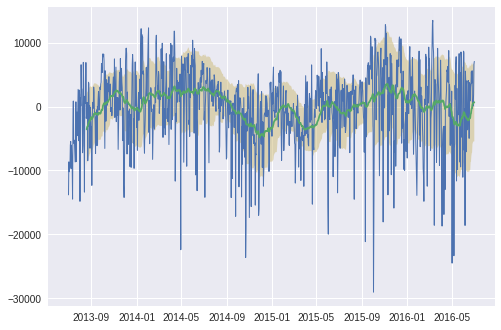

In [69]:
from ipywidgets import interact

def plot_rolling(x):
    
    def func(window=50):
        rolling = x.rolling(window=window)
        plt.plot(x, lw=1)
        mean = rolling.mean()
        std = rolling.std()
        plt.fill_between(mean.index, mean+std, mean-std, facecolor=cols[1], alpha=0.5)
        plt.plot(rolling.mean())
    
    return func

interact(plot_rolling(residuals), window=(5, 100, 5))

If we use these rolling values for mean and standard deviation, we get the **moving z-score**.

In [70]:
def rolling_z(x, window):
    roll_mean = x.rolling(window=window).mean().shift(1) # Don't include current data
    roll_std = x.rolling(window=window).std().shift(1)
    return (x - roll_mean) / roll_std

<function __main__.<lambda>>

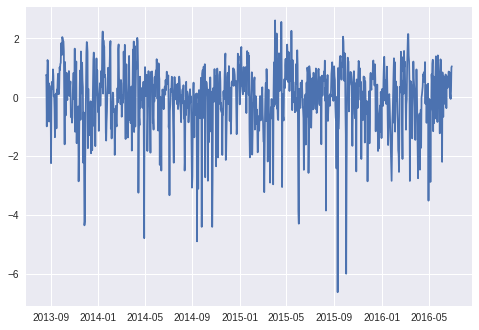

In [71]:
def plot_rolling_z(x):
    return lambda window: plt.plot(rolling_z(x, window)) and None

interact(plot_rolling_z(residuals), window=(5, 100, 5))

While the choice of window size will always reflect a balance between the need to respond to new baselines while still noticing anomalous behavior, we can get an estimate for the size of the window we should use from the autocorrelation of the residuals.  In this case, the strong correlation only lasts about 5 days.

/opt/conda/lib/python2.7/site-packages/ipykernel_launcher.py:1: FutureWarning: 'pandas.tools.plotting.autocorrelation_plot' is deprecated, import 'pandas.plotting.autocorrelation_plot' instead.
  """Entry point for launching an IPython kernel.


(0, 40)

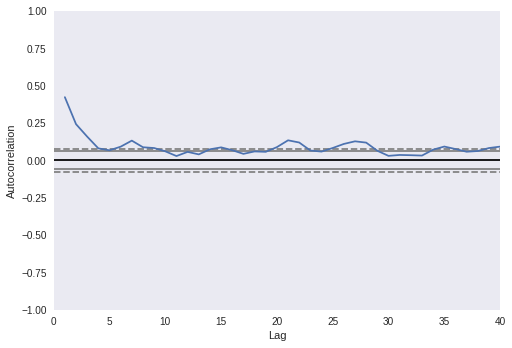

In [72]:
pd.tools.plotting.autocorrelation_plot(residuals)
plt.xlim(0,40)

In [73]:
rolling_z(residuals, 5)[rolling_z(residuals, 5) > 5]

dt
2013-10-28    5.600237
2014-03-08    6.210163
2015-09-24    5.153240
Name: starttime, dtype: float64

In [74]:
rolling_z(residuals, 5)[rolling_z(residuals, 5) < -10]

dt
2013-10-06   -16.670652
2014-07-02   -10.080202
2014-09-13   -16.849386
2014-10-01   -14.506062
2014-10-11   -13.980488
2014-11-01   -10.928027
2015-03-28   -10.182186
2015-11-26   -11.189694
Name: starttime, dtype: float64

### Exponential Window

A particularly simple windowing average is the **exponentially-weighted moving average** (EWMA).  The value at time $t$ is given by

$$ E_t = \alpha X_t + (1 - \alpha) E_{t-1}\ . $$

This has the effect of previous measurements fade away by a factor of $1 - \alpha$ each step.  Previous values are never entirely forgotten, but they fade away bit by bit.

There are several ways to specify the parameter; here we use the **half-life**,

$$ h = \log_2 \frac{1}{1-\alpha} \ . $$

<function __main__.func>

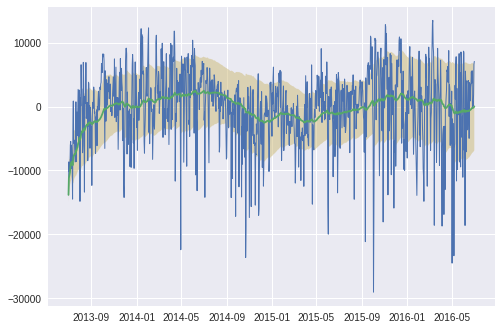

In [75]:
def plot_ewm(x):
    
    def func(halflife=50):
        rolling = x.ewm(halflife=halflife)
        plt.plot(x, lw=1)
        mean = rolling.mean()
        std = rolling.std()
        plt.fill_between(mean.index, mean+std, mean-std, facecolor=cols[1], alpha=0.5)
        plt.plot(rolling.mean())
    
    return func

interact(plot_ewm(residuals), halflife=(5, 100, 5))

In [76]:
def ewm_z(x, halflife):
    ewm_mean = x.ewm(halflife=halflife).mean().shift(1) # Don't include current data
    ewm_std = x.ewm(halflife=halflife).std().shift(1)
    return (x - ewm_mean) / ewm_std

<function __main__.<lambda>>

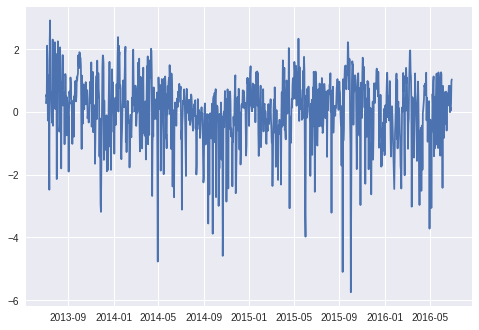

In [77]:
def plot_ewm_z(x):
    return lambda halflife: plt.plot(ewm_z(x, halflife)) and None

interact(plot_ewm_z(residuals), halflife=(5, 100, 5))

In [78]:
ewm_z(residuals, 5)[ewm_z(residuals, 5) > 2]

dt
2013-07-06    2.234652
2013-07-13    2.154178
2013-07-14    2.449677
2013-07-21    2.230437
2013-09-28    2.011006
2013-11-02    2.704277
2014-01-12    2.394464
2014-01-13    2.315972
2014-02-22    2.980048
2014-02-23    2.089400
2014-03-08    2.217679
2014-04-01    2.141728
2015-04-02    2.340731
2015-04-18    2.446755
2015-05-14    2.536678
Name: starttime, dtype: float64

In [79]:
ewm_z(residuals, 5)[ewm_z(residuals, 5) < -4]

dt
2014-04-30   -5.064805
2014-07-04   -4.516854
2014-08-12   -4.823089
2014-09-13   -5.525155
2014-09-25   -4.345008
2014-10-22   -4.819653
2015-04-20   -4.053342
2015-06-01   -4.088024
2015-08-11   -6.486068
2015-09-10   -6.800223
2015-10-02   -5.824760
2016-05-01   -4.793360
Name: starttime, dtype: float64

## Including windowed data in model

Instead of adapting our metric to consider recent data, we can include that recent data in the model.  Here, we two features: the count from the previous day, and a five-day rolling average.  There is a little bit of work necessary to hook all the components of the pipeline together, but in then end there is just a linear regression being performed

In [80]:
counts_df = pd.DataFrame({'counts': counts, 'previous': counts.shift(1).fillna(method='bfill'),
                          'rolling': counts.rolling(window=5).mean().shift(1).fillna(method='bfill')}) 
counts_df

,counts,previous,rolling
dt,,,
2013-07-01,16650,16650.0,21085.4
2013-07-02,22745,16650.0,21085.4
2013-07-03,21864,22745.0,21085.4
2013-07-04,22326,21864.0,21085.4
2013-07-05,21842,22326.0,21085.4
2013-07-06,20467,21842.0,21085.4
2013-07-07,20477,20467.0,21848.8
2013-07-08,21615,20477.0,21395.2
2013-07-09,26641,21615.0,21345.4


In [81]:
class IndexExtractor(base.BaseEstimator, base.TransformerMixin):
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X.index

class ColumnExtractor(base.BaseEstimator, base.TransformerMixin):
    
    def __init__(self, cols):
        self.cols = cols
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        return X[self.cols]

In [82]:
time_pipe = Pipeline([('index', IndexExtractor()),
                      ('features', union)])
all_union = FeatureUnion([('time_pipe', time_pipe),
                          ('columns', ColumnExtractor(['previous', 'rolling']))])
lr_pipe = Pipeline([('all_union', all_union),
                    ('lr', LinearRegression())])

In [83]:
time_pipe

Pipeline(steps=[('index', IndexExtractor()), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('date', QuadBackground()), ('fourier-y', FourierComponents(period=365)), ('fourier-2', FourierComponents(period=182.5)), ('fourier-m', FourierComponents(period=30.4166666667)), ('fourier-8', FourierComponents(period=45.625)), ('dayofweek', DayofWeek())],
       transformer_weights=None))])

In [84]:
type(lr_pipe)

sklearn.pipeline.Pipeline

In [85]:
lr_pipe.fit?

In [86]:
type(time_pipe)

sklearn.pipeline.Pipeline

In [87]:
all_union

FeatureUnion(n_jobs=1,
       transformer_list=[('time_pipe', Pipeline(steps=[('index', IndexExtractor()), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('date', QuadBackground()), ('fourier-y', FourierComponents(period=365)), ('fourier-2', FourierComponents(period=182.5)), ('fourier-m', FourierComponents(period=30.4166666667)), ('fourier-8', FourierComponents(period=45.625)), ('dayofweek', DayofWeek())],
       transformer_weights=None))])), ('columns', ColumnExtractor(cols=['previous', 'rolling']))],
       transformer_weights=None)

In [88]:
all_union.transform(counts_df)

array([[  0.00000000e+00,   0.00000000e+00,   0.00000000e+00, ...,
          0.00000000e+00,   1.66500000e+04,   2.10854000e+04],
       [  1.00000000e+00,   1.00000000e+00,   1.72133562e-02, ...,
          0.00000000e+00,   1.66500000e+04,   2.10854000e+04],
       [  2.00000000e+00,   4.00000000e+00,   3.44216116e-02, ...,
          0.00000000e+00,   2.27450000e+04,   2.10854000e+04],
       ..., 
       [  1.09300000e+03,   1.19464900e+06,  -3.44216116e-02, ...,
          0.00000000e+00,   4.70230000e+04,   4.80814000e+04],
       [  1.09400000e+03,   1.19683600e+06,  -1.72133562e-02, ...,
          0.00000000e+00,   4.95930000e+04,   4.73588000e+04],
       [  1.09500000e+03,   1.19902500e+06,  -7.34788079e-16, ...,
          0.00000000e+00,   5.48820000e+04,   4.74980000e+04]])

In [89]:
type(all_union)

sklearn.pipeline.FeatureUnion

In [90]:
lr_pipe.fit(counts_df, counts_df['counts'])
np.sqrt(metrics.mean_squared_error(counts_df['counts'], lr_pipe.predict(counts_df)))

5280.9055000455455

This models scores significantly better.  It is also much more stationary.

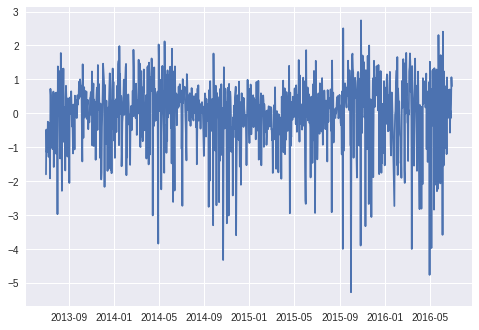

In [91]:
residuals_window = counts_df['counts'] - lr_pipe.predict(counts_df)
z_window = residuals_window / residuals_window.std()
plt.plot(z_window)

In [92]:
z_window[z_window > 2]

dt
2014-05-01    2.029288
2014-05-17    2.119656
2015-09-11    2.504057
2015-10-29    2.738121
2016-05-25    2.306075
2016-06-06    2.406719
Name: counts, dtype: float64

In [93]:
z_window[z_window < -3.5]

dt
2014-04-30   -3.836093
2014-10-22   -4.319922
2014-11-26   -3.589015
2015-09-10   -3.992619
2015-10-02   -5.268593
2015-10-28   -3.892991
2016-03-14   -3.994029
2016-05-01   -4.758097
2016-05-06   -3.966675
2016-06-05   -3.578224
Name: counts, dtype: float64

## Online Learning

So far, we have been doing only retrospective analysis of the data.  In practice, we want to analyze incoming data in real time.  While we could train a model on an initial set of data and use that to analyze the future input, this means we don't learn anything from that future data.  (Extrapolation is also very dangerous if you have a quadratic background term.)

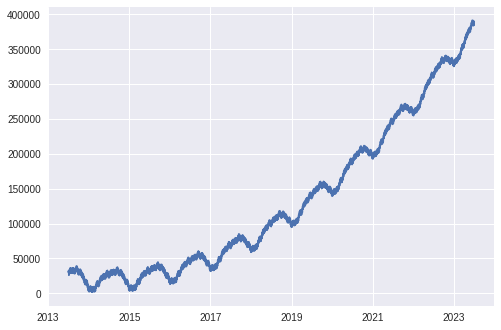

In [94]:
future_dates = pd.date_range('2013-07-01', '2023-07-01', freq='d')
plt.plot(future_dates, pipe.predict(future_dates))

We can avoid retraining the model each time we get new data by using an **online** learning algorithm, which is able to update itself with new data.  An exponentially-weighted moving average can be thought of as a simple online learning algorithm.  We can update its value from only the current value and the new measurement.  (In contrast, a rolling window requires us to store all the values in the window and recalculate the mean each step.)

Linear regression does not support online learning.  However, **stochastic gradient descent** does.  Like linear regression, this is also a linear model.  Instead of finding an exact solution with matrix operations, stochastic gradient descent goes through the data row by row, updating its parameters slightly each time to reduce an error function.  Thus, it naturally supports online learning.

In Scikit Learn, estimators that support online learning do so through a `partial_fit()` method.  Unfortunately, the default `Pipeline` class does not support `partial_fit()`, so we implement it ourselves.

In [98]:
from sklearn.linear_model import SGDRegressor
from sklearn.preprocessing import StandardScaler

class PartialFitPipeline(Pipeline):
    
    def partial_fit(self, X, y):
        # Assume that none of the transformers need to be fit
        Xtrans = X
        for _, step in self.steps[:-1]:
            Xtrans = step.transform(Xtrans)
        self.steps[-1][1].partial_fit(Xtrans, y)
        return self

sgd_pipe = PartialFitPipeline([('all_union', all_union),
                               ('scaler', StandardScaler()),
                               ('sgd', SGDRegressor())])

We use an exponential weighted moving average, since it's easier to manage in online learning.  Stochastic gradient descent is sensitive to different scales of data, so we need to normalize the features coming in.

In [96]:
counts_init = counts.iloc[:700]
counts_online = counts.iloc[700:]
counts_init_df = pd.DataFrame({'counts': counts_init,
                               'previous': counts_init.shift(1).fillna(method='bfill'),
                               'rolling': counts_init.ewm(halflife=5).mean().shift(1).fillna(method='bfill')}) 
sgd_pipe.fit(counts_init_df, counts_init_df['counts'])

PartialFitPipeline(steps=[('all_union', FeatureUnion(n_jobs=1,
       transformer_list=[('time_pipe', Pipeline(steps=[('index', IndexExtractor()), ('features', FeatureUnion(n_jobs=1,
       transformer_list=[('date', QuadBackground()), ('fourier-y', FourierComponents(period=365)), ('fourier-2', FourierComponents(perio..., penalty='l2', power_t=0.25,
       random_state=None, shuffle=True, verbose=0, warm_start=False))])

At each step, we make a prediction for the incoming record.  Then we train the model on the new record and update for the next record.

In [97]:
last_count = counts_init_df['counts'].iloc[-1]
alpha = 1 - 1./2**5
ewm = counts_init_df['rolling'].iloc[-1]
predictions = []
coefs = []

for date, count in counts_online.iteritems():
    df = pd.DataFrame({'counts': count, 'previous': last_count, 'rolling': ewm}, index=[date])
    predictions.append(sgd_pipe.predict(df))
    sgd_pipe.partial_fit(df, df['counts'])
    coefs.append(sgd_pipe.named_steps['sgd'].coef_.copy())
    last_count = count
    ewm = alpha * count + (1 - alpha) * ewmdw

NameError: name 'ewmdw' is not defined

In [ ]:
plt.plot(counts_online, label='data')
plt.plot(counts_online.index, predictions, label='model')
plt.legend(loc=4)

In [ ]:
plt.plot(counts_online.index, np.concatenate(predictions) - counts_online.values, label='residuals')
plt.legend(loc=4)
np.sqrt(metrics.mean_squared_error(counts_online.values, np.concatenate(predictions)))

We can see that the model is adjusting the coefficients over time, as it continues to learn from the new data.

In [ ]:
plt.plot(coefs)

## Excercises

1. Add more lagged or windowed data to the model, and see if its performance can be improved.  Beware that, if too many features are added, there is a danger of "overfitting".  To see if this is happening, hold back some data as a "test" set, and compare the model's performance on the training and test sets.

    We will discuss overfitting in more detail in the recommendation sessions.

2. Perform anomaly detection on the temperature data from the Central Park weather station.  Do temperature anomalies tend to align with ridership anomalies?  Add features to the ridership model corresponding to the temperature anomaly.  How does the performace of this model compare to one that involves temperature directly?

3. We have been looking at only aggregate data so far.  Instead, look at the ridership at a particular station, and try to detect anomalies in its data.  Do these anomalies line up wit the system-wide anomalies or not?

## Bayesian Changepoints

The previous model does a good job at producing a stationary signal, but there appear to be occasional changes in the variance.  One tool to deal with this is **Bayesian changepoint detection**.

[Bayesian changepoint detection](https://hips.seas.harvard.edu/files/adams-changepoint-tr-2007.pdf) assumes that we have a signal drawn i.i.d. from some distribution.  However, at some (randomly occuring) points in time, the parameters of that distribution change.  We keep a estimate of the probability that it has been $T$ steps from the last changepoint, for all values of $T$.  As each new measurement $X_t$ comes in, we update the probabilities for each length run, conditioned on the newest measurement.  (Therefore, we need to track the mostly-probable parameters for the distribution, given each length run.)

The algorithm needs to know what the underlying distribution is, what the Bayesian priors of the parameters are, and what the expected distribution of run lengths is.  The implementation below uses a Gaussian distribution for the samples and a geometric distribution for the run lengths.

In [ ]:
# Adapted from Ryan P. Adams's Matlab code: http://hips.seas.harvard.edu/content/bayesian-online-changepoint-detection

def bayes_changepoint(X, mu0, sigma0, lambda_):
    T = len(X)
    R = np.zeros([T+1, T+1])
    R[0,0] = 1
    
    kappa0 = 1
    alpha0 = 1
    beta0 = sigma0**2 / 2

    muT = np.array(mu0)
    kappaT = np.array(kappa0)
    alphaT = np.array(alpha0)
    betaT = np.array(beta0)

    mp_mean = np.zeros(T)
    mp_std = np.zeros(T)

    maxes = np.zeros(T+1)
    for t in xrange(T):
        xt = (X[t] - muT) / np.sqrt(betaT * (kappaT+1) / (alphaT * kappaT))
        predprobs = stats.t.pdf(xt, 2 * alphaT)
        H = np.ones(t+1) / lambda_

        R[1:t+2, t+1] =  R[:t+1,t] * predprobs * (1 - H)
        R[0,     t+1] = (R[:t+1,t] * predprobs * H).sum()
        R[:,t+1] = R[:,t+1] / R[:,t+1].sum()  # Numerics

        mp = R[:, t+1].argmax()

        muT0 = np.r_[mu0, (kappaT * muT + X[t]) / (kappaT + 1)]
        kappaT0 = np.r_[kappa0, kappaT + 1]
        alphaT0 = np.r_[alpha0, alphaT + 0.5]
        betaT0 = np.r_[beta0, betaT + (kappaT * (X[t] - muT)**2 / (2 * (kappaT + 1)))]

        muT = muT0
        kappaT = kappaT0
        alphaT = alphaT0
        betaT = betaT0

        mp_mean[t] = muT[mp]
        mp_std[t] = np.sqrt(betaT[mp] * (kappaT[mp] + 1) / (alphaT[mp] * kappaT[mp]))
    
    return R, mp_mean, mp_std

In [ ]:
R, mp_mean, mp_std = bayes_changepoint(residuals_window, 0, residuals_window.std(), 1000)
plt.imshow(np.log10(R), vmin=-3, origin='lower')
plt.colorbar()
plt.plot(residuals_window.values/100 + 900, lw=0.5)
plt.plot(R.argmax(axis=0), alpha=0.5, c='y')
plt.axis([0,len(residuals_window),0,len(residuals_window)])

At each point in time, we can find the most probable run length and the mean and standard deviation associated with that run.  This provides another way to calculate a moving z-score.

In [ ]:
plt.plot(residuals_window, lw=1)
plt.fill_between(residuals_window.index, mp_mean+mp_std, mp_mean-mp_std, facecolor=cols[1], alpha=0.5)
plt.plot(residuals_window.index, mp_mean)

In [ ]:
plt.plot(residuals_window / mp_std)